# Nishino's DMRG preprint dataset

## Introduction

For over 20 years, Professor Tomotoshi Nishino has been searching for preprints related to DMRG, tensor networks and other related topics. In his words:

> "Every morning (or evening), he accesses arXiv.org, and search key word such as DMRG, Renormalization, Entropy, Fidelity, Density, etc. from the abstract. After finding out preprints in this way, he reads tytle of most of the preprint listed in arXive again from the top to the bottom, or sometimes looks at authors. Articles detected in this primitive way is listed during the day." (http://quattro.phys.sci.kobe-u.ac.jp/dmrg/admin.html)

Over time he has created an extensive dataset, detailing the evolution of a very interesting corner of the many-body physics community. I have scrapped the arXiv IDs from Nishino's page and obtained the relevant information for each paper via the arXiv API (https://arxiv.org/help/api/index).

## Author network
### Feb. 8, 2019

In this notebook, I will analyze some features of the dataset using the connections between the authors as infered from the articles they have published together. I will do this in two steps:

1. I will obtain the network of collaborations of the dataset in order the characterize the authors in terms of their connections.
2. I will compute variational embeddings both for the papers and the authors in such a way that the inherited distance reflects on the collaboration structure of the dataset.

## Libraries

In [119]:
from itertools import chain
from collections import Counter, OrderedDict
import unidecode

import pandas as pd
import numpy as np
import random

from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

import networkx as nx
from networkx.algorithms.approximation import ramsey_R2
from networkx.algorithms.centrality import closeness_centrality

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Load csv file

We have already created a CSV file containing the relevant information of over 5500 articles.

In [2]:
arxiv = pd.read_csv('../data/arxiv_search.csv')
arxiv.shape

(5590, 7)

In [3]:
arxiv.head()

,arXiv_id,Nishino_Rating,title,authors,submitted,abstract,doi
0,cond-mat/9812409,0,Phase diagram of a Heisenberg spin-Peierls mod...,Robert J. Bursill|Ross H. McKenzie|Chris J. Hamer,1998-12-29 02:54:03,Using a new version of the density-matrix re...,10.1103/PhysRevLett.83.408
1,cond-mat/9812374,0,Modified Double Exchange Model with Novel Spin...,L. Sheng|C. S. Ting,1998-12-22 22:02:14,From a general model of the Mn oxides R_{1-x...,NaN
2,cond-mat/9812372,1,Dynamical Correlation Functions using the Dens...,Till D. Kuehner|Steven R. White,1998-12-22 19:23:21,The density matrix renormalization group (DM...,10.1103/PhysRevB.60.335
3,cond-mat/9812353,1,Dynamical properties of the one-dimensional Ho...,Chunli Zhang|Eric Jeckelmann|Steven R. White,1998-12-22 01:53:07,The spectral weight functions and the optica...,10.1103/PhysRevB.60.14092
4,cond-mat/9812349,0,A density matrix renormalisation group algorit...,R. J. Bursill,1998-12-22 02:26:14,A variant of White's density matrix renormal...,10.1103/PhysRevB.60.1643


In [4]:
arxiv.tail()

,arXiv_id,Nishino_Rating,title,authors,submitted,abstract,doi
5585,1801.00842,0,Absence of long-range order in a triangular sp...,Ahmet Keles|Erhai Zhao,2018-01-02 21:35:17,Antiferromagnetic Heisenberg model on the tr...,NaN
5586,1801.00315,0,Learning Relevant Features of Data with Multi-...,E. M. Stoudenmire,2017-12-31 16:53:12,Inspired by coarse-graining approaches used ...,NaN
5587,1801.00769,0,Quasiparticles in quantum spin chains with lon...,Laurens Vanderstraeten|Maarten Van Damme|Hans ...,2018-01-02 18:49:02,We study quasiparticle excitations for quant...,NaN
5588,1801.00719,0,Lattice model constructions for gapless domain...,Chenfeng Bao|Shuo Yang|Chenjie Wang|Zheng-Chen...,2018-01-02 16:44:10,Lattice models of gapless domain walls betwe...,NaN
5589,1801.00142,0,Energy Scales and Exponential Speedup in Therm...,Bin-Bin Chen|Lei Chen|Ziyu Chen|Wei Li|Andreas...,2017-12-30 15:23:03,"In this work, we exponentially speed up ther...",NaN


These preprints were submitted to arXiv between January 1998 and March 2018.

In [5]:
arxiv.submitted = pd.to_datetime(arxiv.submitted)
arxiv.submitted.min(), arxiv.submitted.max()

(Timestamp('1998-01-07 16:12:32'), Timestamp('2018-04-18 13:41:42'))

For this particular analysis, we will not use the abstract and publication details.

In [6]:
arxiv.drop(['doi', 'abstract'], axis=1, inplace=True)

We will remove rows that have invalid author information.

In [7]:
arxiv.authors = arxiv.authors.map(lambda x : np.NaN if x == 'nan' else x)

In [8]:
arxiv.dropna(inplace=True)
arxiv.shape

(5589, 5)

# Create list of authors

The arXiv API lists authors by separating them using a vertical bar "|", making it easy to parse them into a list. However, as people familiar with the arXiv are aware, name spelling is rarely consistent. Some papers list their authors using full names, while other use only initials for the given names. We will encode authors using the first letter of the name and the last word:

In [9]:
arxiv.iloc[0].authors

'Robert J. Bursill|Ross H. McKenzie|Chris J. Hamer'

In [10]:
arxiv.iloc[0].authors.split('|')

['Robert J. Bursill', 'Ross H. McKenzie', 'Chris J. Hamer']

In [11]:
for author in arxiv.iloc[0].authors.split('|'):
    name = author.split(' ')
    name = name[0][0] + ' ' + name[-1]
    name = name.lower()
    print(name)

r bursill
r mckenzie
c hamer


This method is very efficient. However, it is far from perfect, in particular in the context of certain Chinese names.

We will also need to strip the names from accents:

In [12]:
def cleanText (df, column):
    df[column] = df[column].str.replace('ä', 'ae')
    df[column] = df[column].str.replace('ö', 'oe')
    df[column] = df[column].str.replace('ü', 'ue')
    df[column] = df[column].apply(lambda x : unidecode.unidecode(x))
    
    return df

In [13]:
arxiv = cleanText(arxiv, 'authors')

In [16]:
arxiv.head()

,arXiv_id,Nishino_Rating,title,authors,submitted
0,cond-mat/9812409,0,Phase diagram of a Heisenberg spin-Peierls mod...,Robert J. Bursill|Ross H. McKenzie|Chris J. Hamer,1998-12-29 02:54:03
1,cond-mat/9812374,0,Modified Double Exchange Model with Novel Spin...,L. Sheng|C. S. Ting,1998-12-22 22:02:14
2,cond-mat/9812372,1,Dynamical Correlation Functions using the Dens...,Till D. Kuehner|Steven R. White,1998-12-22 19:23:21
3,cond-mat/9812353,1,Dynamical properties of the one-dimensional Ho...,Chunli Zhang|Eric Jeckelmann|Steven R. White,1998-12-22 01:53:07
4,cond-mat/9812349,0,A density matrix renormalisation group algorit...,R. J. Bursill,1998-12-22 02:26:14


We will now create a dictionary to relate the arXiv id to the list of its authors: 

In [17]:
paperDic = dict()

In [18]:
# Create a list of papers that throw errors while parsing the author list
damagedAuthors = []
for index, row in arxiv.iterrows():
    cleanAuthors = []
    try:
        for author in row['authors'].split('|'):
            name = author.split(' ')
            name = name[0][0] + ' ' + name[-1]
            name = name.lower()
            cleanAuthors.append(name)
        paperDic[row['arXiv_id']] = cleanAuthors
    except:
        damagedAuthors.append(row['arXiv_id'])

No damaged papers:

In [19]:
damagedAuthors

[]

In [20]:
def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

We can now count how many times each author appear in the dataset:

In [21]:
authors_count = count_items(list(chain(*[paperDic[paper] for paper in paperDic])))
list(authors_count.items())[:10]

[('f verstraete', 130),
 ('j cirac', 126),
 ('s white', 101),
 ('u schollwoeck', 100),
 ('i mcculloch', 90),
 ('g vidal', 84),
 ('o legeza', 72),
 ('a feiguin', 66),
 ('p calabrese', 63),
 ('f pollmann', 60)]

We will only consider authors that appear more than 3 times in the dataset:

In [22]:
for paper in paperDic:
    paperDic[paper] = [author for author in paperDic[paper] if authors_count[author] > 3]

This restriction leaves us with over 1000 different authors:

In [23]:
uniqueAuthors = set(list(chain(*[paperDic[paper] for paper in paperDic if paperDic[paper] != []])))
print(f"There are {len(uniqueAuthors)} unique authors.")

There are 1159 unique authors.


In [24]:
authors_count = count_items(list(chain(*[paperDic[paper] for paper in paperDic if paperDic[paper] != []])))
list(authors_count.items())[:10]

[('f verstraete', 130),
 ('j cirac', 126),
 ('s white', 101),
 ('u schollwoeck', 100),
 ('i mcculloch', 90),
 ('g vidal', 84),
 ('o legeza', 72),
 ('a feiguin', 66),
 ('p calabrese', 63),
 ('f pollmann', 60)]

## Create dictionaries for the papers and the authors

In order to speed up our calculations, it is standard to create a simple dictionary were we encode the different entities with numbers:

In [25]:
paper_index = {paper: idx for idx, paper in enumerate(paperDic)}
index_paper = {idx: paper for paper, idx in paper_index.items()}

In [26]:
paper_index['cond-mat/9812349']
index_paper[4]

'cond-mat/9812349'

In [27]:
author_index = {author: idx for idx, author in enumerate(uniqueAuthors)}
index_author = {idx: author for author, idx in author_index.items()}

In [28]:
author_index['t nishino']

1047

# Basic network analysis

The information we have makes it easy to create a network of authors. We will use the nodes to model the authors and the edges to model the papers. I am not an expert on networks, so this will be a very simple analysis.

In [30]:
full_net = []

for paper in paperDic:
    paperAuthors = paperDic[paper]
    for i in range(len(paperAuthors)-1):
        for j in range(i+1, len(paperAuthors)):
            full_net.append((paperAuthors[i],paperAuthors[j]))

We will weight the edges using a logarithmic scale:

In [31]:
count_net = Counter(full_net)
G_full = nx.Graph()

for edge in count_net:
    G_full.add_edge(edge[0],edge[1], weight=np.log(count_net[edge]+1))

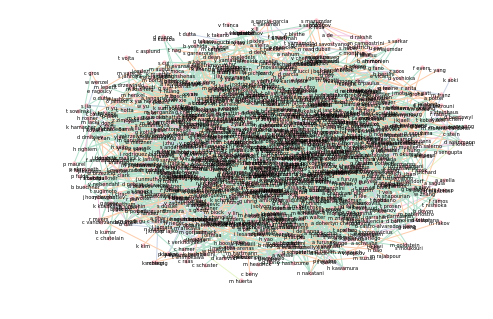

In [123]:
pos = nx.spring_layout(G_full,
                       k=10/np.sqrt(G_full.order())) # This parameters controls optimal edge separation

edges,weights = zip(*nx.get_edge_attributes(G_full,'weight').items())

nx.draw(G_full, pos = pos,
        node_size=12, node_color='pink',
        alpha=1.0, arrows=False,
        edgelist=edges, edge_color=weights, width=1.0, edge_cmap=plt.cm.Pastel2,
        with_labels=True, font_size=5)

plt.savefig("fullGraph.pdf")

It is hard to read information from the graph presented in this way. In order to gain some insight, we can use some techniques from network theory:

First, a simple histogram shows us that most authors are connected by a single paper:

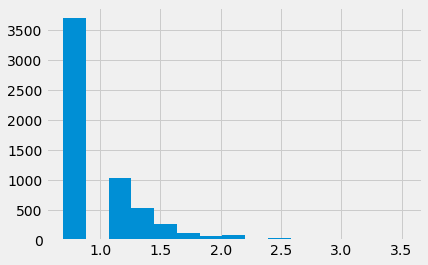

In [124]:
plt.hist(np.array(weights), bins=15);

We can extract the dominating set of the graph. This object is defined as:

>"A dominating set for a graph with node set $V$ is a subset $D$ of $V$ such that every node not in $D$ is adjacent to at least one member of $D$."

Note that a dominating set may not be unique. We will start growing the set using Frank Verstraete, the most prolific author in the dataset.

In [39]:
dom_set = nx.algorithms.dominating_set(G_full, start_with='f verstraete')
dom_set

{'a abdelwahab',
 'a aligia',
 'a allerdt',
 'a avella',
 'a bishop',
 'a chandran',
 'a chen',
 'a chernyshev',
 'a chin',
 'a coser',
 'a darmawan',
 'a ferris',
 'a garcia-saez',
 'a green',
 'a iucci',
 'a kallin',
 'a kampf',
 'a kawaguchi',
 'a kleine',
 'a kluemper',
 'a kshetrimayum',
 'a langari',
 'a lobos',
 'a luca',
 'a maciolek',
 'a mitchell',
 'a mollabashi',
 'a muramatsu',
 'a nahum',
 'a nevidomskyy',
 'a nielsen',
 'a osterloh',
 'a parola',
 'a parvej',
 'a polkovnikov',
 'a potter',
 'a rahmani',
 'a riera',
 'a saguia',
 'a sandvik',
 'a sanpera',
 'a seidel',
 'a surda',
 'a trumper',
 'a vieira',
 'a zheludev',
 'b ammon',
 'b buechner',
 'b damski',
 'b dittrich',
 'b dora',
 'b doyon',
 'b estienne',
 'b paulus',
 'b powell',
 'b schmidt',
 'b swingle',
 'b zeng',
 'c asplund',
 'c beny',
 'c chatelain',
 'c clark',
 'c gros',
 'c herdman',
 'c hotta',
 'c huang',
 'c lee',
 'c monthus',
 'c mou',
 'c peng',
 'c pinettes',
 'c schuster',
 'c stein',
 'c yang'

In [40]:
len(dom_set)

342

Let us also look at the edges with the highest closeness centrality. This is a measure of the average distance between a node and the rest of the graph:

$$C(x) = \frac{N-1}{\sum_y d(x,y)},$$

where $N$ is the total number of nodes and $d(x,y)$ is the minimum graph distance.

In [42]:
closeness_cent = closeness_centrality(G_full)
sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:20]

[('u schollwoeck', 0.40249999999999997),
 ('m troyer', 0.39529706513958485),
 ('a feiguin', 0.3951556350626118),
 ('i mcculloch', 0.3906827025114963),
 ('f verstraete', 0.39026855123674914),
 ('a laeuchli', 0.3880744905130007),
 ('s white', 0.38402642559109873),
 ('p corboz', 0.38163787145818934),
 ('r noack', 0.38124266482568175),
 ('g vidal', 0.3763066439522998),
 ('j cirac', 0.37452017633095963),
 ('d poilblanc', 0.3742663503896984),
 ('s trebst', 0.3733806626098715),
 ('b bauer', 0.370127345844504),
 ('s manmana', 0.3643879907621247),
 ('a weichselbaum', 0.36378787878787877),
 ('j delft', 0.3584745212593314),
 ('e gull', 0.35835820895522386),
 ('l wang', 0.3573147848592688),
 ('i affleck', 0.3563923846402065)]

We see that there are several authors that are very well connected with the rest of the network. This is consistent with the size we obtained for the dominating set (roughly one third of the full network).

### Prolific subnetwork

Let us now consider only the most prolific authors in the dataset (more than 30 papers). We will connect them only if they have co-authored 3 or more papers, so that we can see long-standing collaborations in a better way.

In [43]:
new_net = []

# Minimum number of papers in the list
min_papers = 30

for paper in paperDic:
    paperAuthors = paperDic[paper]
    for i in range(len(paperAuthors)-1):
        if authors_count[paperAuthors[i]] > min_papers:
            for j in range(i+1, len(paperAuthors)):
                if authors_count[paperAuthors[j]] > min_papers:
                    new_net.append((paperAuthors[i],paperAuthors[j]))

In [44]:
count_net = Counter(new_net)

In [45]:
G_prolific = nx.Graph()

# Connect only authors that share 3 or more papers 
count_net = {edge: count_net[edge] for edge in count_net if count_net[edge] > 2}

for edge in count_net:
    G_prolific.add_edge(edge[0],edge[1], weight=np.log(count_net[edge]+1))

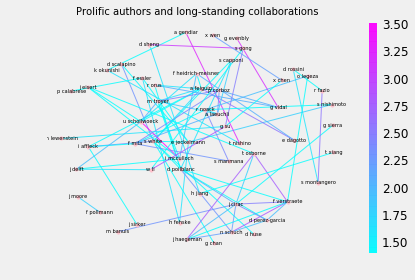

In [170]:
pos = nx.spring_layout(G_prolific,
                       k=10/np.sqrt(G_prolific.order()))

edges,weights = zip(*nx.get_edge_attributes(G_prolific,'weight').items())

nodes = nx.draw_networkx_nodes(G_prolific, pos,
                               node_size=12, node_color='pink',
                               alpha=1.0)
edges = nx.draw_networkx_edges(G_prolific, pos, alpha=0.8,
                               arrows=False,  edgelist=edges,
                               edge_color=weights, width=1.0,
                               edge_cmap=plt.cm.cool)
labels = nx.draw_networkx_labels(G_prolific, pos,
                                 with_labels=True, font_size=5)

plt.title("Prolific authors and long-standing collaborations", {'fontsize': 10})

# Add colorbar and appropriate labels
cbar = plt.colorbar(edges)
cbar.ax.tick_params(labelsize=12)
plt.axis('off')

plt.savefig("prolificGraph.pdf")

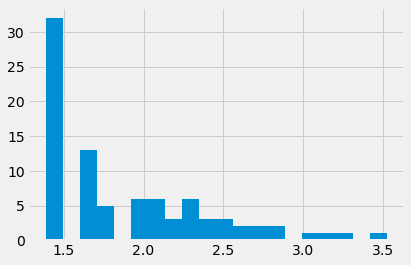

In [126]:
plt.hist(np.array(weights), bins=20);

We can find the maximum clique (subgraph were everyone is connected among each other) and the maximum independent set using the function ```ramsey_R2```:

In [48]:
ramsey_R2(G_prolific)

({'d perez-garcia', 'd poilblanc', 'f verstraete', 'j cirac', 'n schuch'},
 {'d huse',
  'd poilblanc',
  'e dagotto',
  'e jeckelmann',
  'f pollmann',
  'g chan',
  'g sierra',
  'g vidal',
  'h jiang',
  'i affleck',
  'm banuls',
  'm lewenstein',
  'p calabrese',
  'r noack',
  's gong',
  's montangero',
  't nishino',
  't osborne',
  'u schollwoeck',
  'x chen'})

We can repeat for this subgraph the closeness centrality calculation:

In [49]:
closeness_cent = closeness_centrality(G_prolific)
sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:10]

[('m troyer', 0.29462545252018935),
 ('s white', 0.2902606310013717),
 ('d poilblanc', 0.2902606310013717),
 ('a feiguin', 0.28602324952689917),
 ('u schollwoeck', 0.2839506172839506),
 ('i affleck', 0.2629878200347999),
 ('i mcculloch', 0.2629878200347999),
 ('a laeuchli', 0.2577972709551657),
 ('s capponi', 0.249587166784619),
 ('f verstraete', 0.24338624338624337)]

As we see, this subgraph is still very well connected.

## Similarity of papers and authors based on the graph

We will now consider a different approach to this general problem. We will try to embed authors in a vector space and papers in its dual in such a way that 
$$<paper|person> \approx 1$$
if the person is one of the authors of the paper and
$$<paper|person> \approx -1$$
if it is not. Optimizing these embeddings will induce a metric on the authors in such a way that common co-authors will be close together, and similarly for papers.

This is inpired by the book recommendation system obtained from Wikipedia metadata written by Will Koehrsen: https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/notebooks/Book%20Recommendation%20System.ipynb

First, we compute all the (paper, author) pairs:

In [50]:
pairs = []

# Iterate through each book
for paper in paperDic:
    # Iterate through the links in the book
    pairs.extend((paper_index[paper], author_index[author]) for author in paperDic[paper] \
                 if paperDic[paper] != [])

In [51]:
len(pairs)

12284

In [52]:
pairs = np.array(pairs)
pairs.shape

(12284, 2)

As we mentioned before, the way we obtained the names is not perfect. We can see this in the repeated entries that appear in the (paper,author) list:

In [53]:
unique, counts = np.unique(pairs, return_counts=True, axis = 0)
repeatedPairs = unique[counts>1]
repeatedPairs

array([[1752, 1135],
       [3398,  410],
       [3680,  709],
       [3781,  410],
       [5255,  400]])

In [54]:
index_author[1135]

'f mancini'

In [55]:
index_author[410]

'y zhao'

In [56]:
index_author[709]

'w zhang'

In [57]:
index_author[400]

'y lin'

We can define a set of unique pairs:

In [58]:
pairs_set = np.unique(pairs, axis = 0)

In [59]:
len(pairs_set)

12279

Now that we have the pairs, we can start finding a good embedding. We will do this using standard methods of stochastic gradient descent. In order to do the training, we will generate batches in the following way:
- First, we will choose randomly among the pairs $n_{positive}$ examples. We will label the expected result as +1.
- Then, we will sample $r_{negative}n_{positive}$ (we call $r_{negative}$ the negative sampling ratio) random pairs in such a way that they are NOT in the pair list. These are "incorrect" pairs, so we will label the expected result as -1.

In [130]:
# Random seed for reproducibility
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Label based on task
    neg_label = -1
    
    # Unique (paper, author) pairs
    pairs_set = np.unique(pairs, axis = 0)
    
    # Unique papers and authors in pairs
    un_papers = np.unique(pairs[:,0])
    un_authors = np.unique(pairs[:,1])
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        pos_sample = pairs[np.random.choice(pairs.shape[0], n_positive, replace=False)]
        for idx, (paper_id, author_id) in enumerate(pos_sample):
            batch[idx, :] = (paper_id, author_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_paper = random.choice(un_papers)
            random_author = random.choice(un_authors)
            
            # Check to make sure this is not a positive example
            if len(np.where((pairs_set == (random_paper,random_author)).all(axis=1))[0]) == 0:
                
                # Add to batch and increment index
                batch[idx, :] = (random_paper, random_author, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'paper': batch[:, 0], 'author': batch[:, 1]}, batch[:, 2]

We can generate a small example to see how this works:

In [131]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'paper': array([2869., 4145., 3583., 1286., 4169., 3966.]),
  'author': array([ 714.,  458.,  716.,  941.,  357., 1038.])},
 array([ 1.,  1., -1., -1., -1., -1.]))

In [132]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Show a few example training pairs
for label, p_idx, a_idx in zip(y, x['paper'], x['author']):
    print(f'Paper: {index_paper[p_idx]:30} Author: {index_author[a_idx]:40} Label: {label}') 

Paper: 0711.3960                      Author: m sanz                                   Label: -1.0
Paper: 1601.00648                     Author: a honecker                               Label: 1.0
Paper: 1505.06495                     Author: a miyake                                 Label: -1.0
Paper: 1012.4270                      Author: a hamma                                  Label: 1.0
Paper: 0705.3584                      Author: h aoki                                   Label: -1.0
Paper: cond-mat/0312707               Author: e ragoucy                                Label: -1.0


We now define our embedding model. We mentioned before, we will create a matrix to embed all the different names into a vector space of fixed dimensions and then optimize using the dot product of the representations.

In [133]:
def paper_embedding_model(num_papers,
                          num_authors,
                          embedding_size = 40):
    """Model to embed papers and authors using the functional API.
       Trained to discern if an author is present in a paper"""
    
    # Both inputs are 1-dimensional
    paper = Input(name = 'paper', shape = [1])
    author = Input(name = 'author', shape = [1])
    
    # Embedding the paper (shape will be (None, 1, embedding_size))
    paper_embedding = Embedding(name = 'paper_embedding',
                               input_dim = num_papers,
                               output_dim = embedding_size)(paper)
    
    # Embedding the author (shape will be (None, 1, embedding_size))
    author_embedding = Embedding(name = 'author_embedding',
                               input_dim = num_authors,
                               output_dim = embedding_size)(author)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([paper_embedding, author_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # Loss function is mean squared error
    model = Model(inputs = [paper, author], outputs = merged)
    model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

We instantiate the model using an embedding size (i.e., dimension of the embedding vector space) of 70. We want the vector space to be large enough to represent the differences between the elements, but not so large that the model becomes to expensive. Given that we are aiming at exploring the data we have, we will not need anything too sophisticated to extract useful information.

In [138]:
# Instantiate model and show parameters
model = paper_embedding_model(len(paperDic), len(uniqueAuthors), embedding_size = 70)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
paper (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
author (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
paper_embedding (Embedding)     (None, 1, 70)        391230      paper[0][0]                      
__________________________________________________________________________________________________
author_embedding (Embedding)    (None, 1, 70)        81130       author[0][0]                     
__________________________________________________________________________________________________
dot_produc

We are ready to train!

In [139]:
n_positive = 1200

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit_generator(gen, epochs = 20, 
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 2)

Epoch 1/20
 - 6s - loss: 0.9774
Epoch 2/20
 - 6s - loss: 0.9146
Epoch 3/20
 - 6s - loss: 0.8441
Epoch 4/20
 - 6s - loss: 0.8036
Epoch 5/20
 - 6s - loss: 0.7510
Epoch 6/20
 - 6s - loss: 0.7630
Epoch 7/20
 - 6s - loss: 0.6842
Epoch 8/20
 - 6s - loss: 0.6441
Epoch 9/20
 - 6s - loss: 0.6428
Epoch 10/20
 - 6s - loss: 0.6253
Epoch 11/20
 - 6s - loss: 0.6360
Epoch 12/20
 - 6s - loss: 0.6144
Epoch 13/20
 - 6s - loss: 0.5864
Epoch 14/20
 - 6s - loss: 0.5870
Epoch 15/20
 - 6s - loss: 0.5873
Epoch 16/20
 - 6s - loss: 0.5328
Epoch 17/20
 - 6s - loss: 0.5273
Epoch 18/20
 - 6s - loss: 0.5683
Epoch 19/20
 - 6s - loss: 0.6047
Epoch 20/20
 - 6s - loss: 0.5093


This is not a perfect model, we will still be able to extract useful information.

In [140]:
model.save('./embedding_model_dim_70.h5')

## Using the author embedding

We extract and normalize the weights obtained for the embedding of the authors:

In [141]:
# Extract embeddings
author_layer = model.get_layer('author_embedding')
author_weights = author_layer.get_weights()[0]
author_weights.shape

(1159, 70)

In [142]:
author_weights = author_weights / np.linalg.norm(author_weights, axis = 1).reshape((-1, 1))

We can define a simple function that can give us, starting from a particular author, both the most similar and disimilar authors according to the embedding:

In [143]:
plt.rcParams['font.size'] = 15

def find_similar(name, weights,
                 ent_index,
                 index_ent,
                 n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar entities to name based on embeddings. Option to also plot the results"""
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[ent_index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:n]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [index_ent[c] for c in furthest]
        items.extend(index_ent[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = 'Most and Least Similar'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'Furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'Closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(index_ent[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_ent[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')
        
    

In [144]:
find_similar('t nishino', author_weights, author_index, index_author)

Closest to t nishino.

t nishino    Similarity: 1.0
a gendiar    Similarity: 0.89
r krcmar     Similarity: 0.71
k ueda       Similarity: 0.59
k okunishi   Similarity: 0.56
h ueda       Similarity: 0.56
j genzor     Similarity: 0.54
n maeshima   Similarity: 0.53
y hieida     Similarity: 0.51
k kusakabe   Similarity: 0.46


In [145]:
find_similar('t nishino', author_weights, author_index, index_author, least = True, n = 5)

Furthest from t nishino.

l fidkowski   Similarity: -0.33
a herzog      Similarity: -0.33
l wang        Similarity: -0.34
r konik       Similarity: -0.34
y zhang       Similarity: -0.43


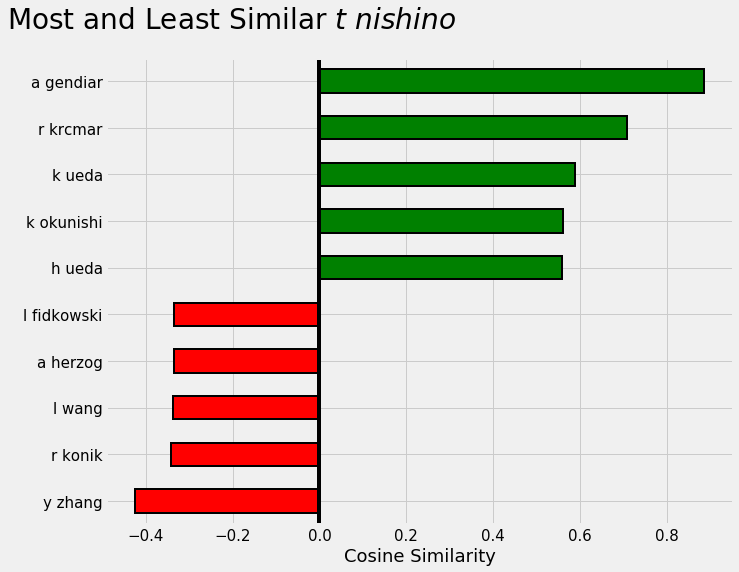

In [146]:
find_similar('t nishino', author_weights, author_index, index_author, n = 5, plot = True)

## Using the paper embedding

We repeat the same computations with the embeddings for the papers:

In [147]:
# Extract embeddings
paper_layer = model.get_layer('paper_embedding')
paper_weights = paper_layer.get_weights()[0]
paper_weights.shape

(5589, 70)

In [148]:
paper_weights = paper_weights / np.linalg.norm(paper_weights, axis = 1).reshape((-1, 1))

Let us use:
*Weak correlation effects in the Ising model on triangular-tiled hyperbolic lattices*, by Andrej Gendiar, Roman Krcmar, Sabine Andergassen, Michal Daniska, Tomotoshi Nishino (https://arxiv.org/abs/1205.3850)

as example

In [149]:
find_similar('1205.3850', paper_weights, paper_index, index_paper)

Closest to 1205.3850.

1205.3850          Similarity: 1.0
1012.1472          Similarity: 0.73
1612.07611         Similarity: 0.71
1403.5377          Similarity: 0.7
0810.0622          Similarity: 0.66
0807.0150          Similarity: 0.65
1512.09059         Similarity: 0.65
1510.01450         Similarity: 0.65
cond-mat/0605411   Similarity: 0.64
cond-mat/0401115   Similarity: 0.64


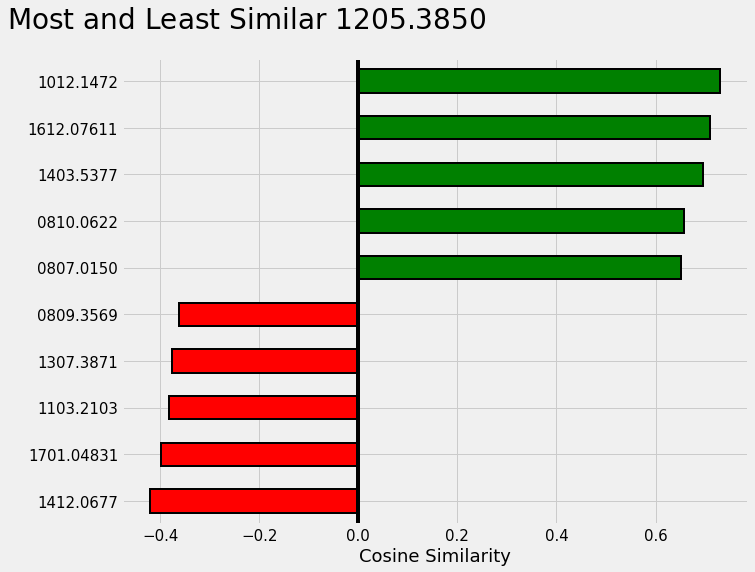

In [150]:
find_similar('1205.3850', paper_weights, paper_index, index_paper, n = 5, plot = True)

## Dimensionality reduction

We can gain more information about the embeddings by considering a dimensional reduction. We will use the t-distributed stochastic neighbor embedding (t-SNE) (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding):

In [151]:
author_dim_red = TSNE(2, metric = 'cosine').fit_transform(author_weights)

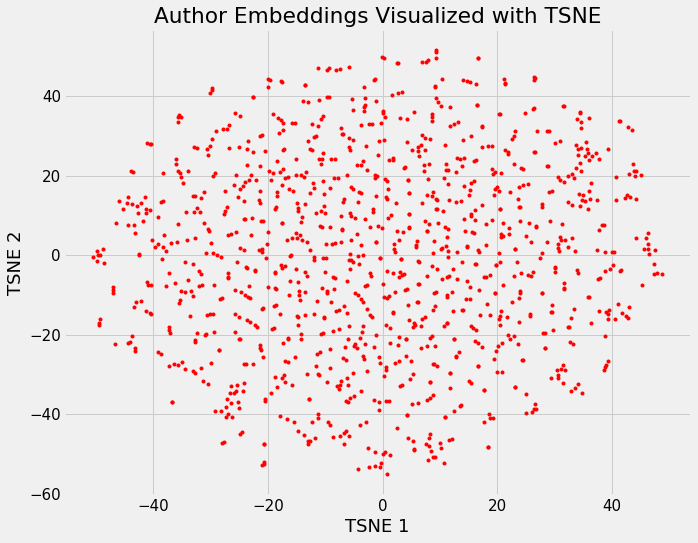

In [152]:
plt.figure(figsize = (10, 8))
plt.plot(author_dim_red[:, 0], author_dim_red[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Author Embeddings Visualized with TSNE');

First, we will locate the most prolific authors in the dataset. Note that there is a collision of Ulrich Schollwoeck and Ian McCulloch, two frequenc collaborators.

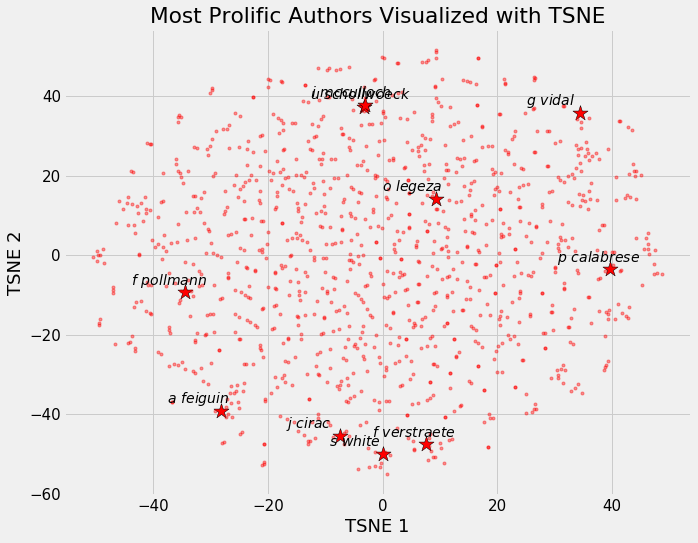

In [159]:
plt.figure(figsize = (10, 8))
plt.plot(author_dim_red[:, 0], author_dim_red[:, 1], 'r.', alpha = 0.4)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Most Prolific Authors Visualized with TSNE');

for author in list(authors_count.keys())[:10]:
    
    x, y = author_dim_red[author_index[author], 0], author_dim_red[author_index[author], 1];
    # Italize book title using latex
    s =  ''.join([' $\it{' + word + '}$' for word in author.split()])
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k')
    _ = plt.text(x - 10, y + 2, s, fontsize = 14);

Going back to the information we got using the author network, we can see that the dominating set spans the whole cloud (as one would reasonably expect).

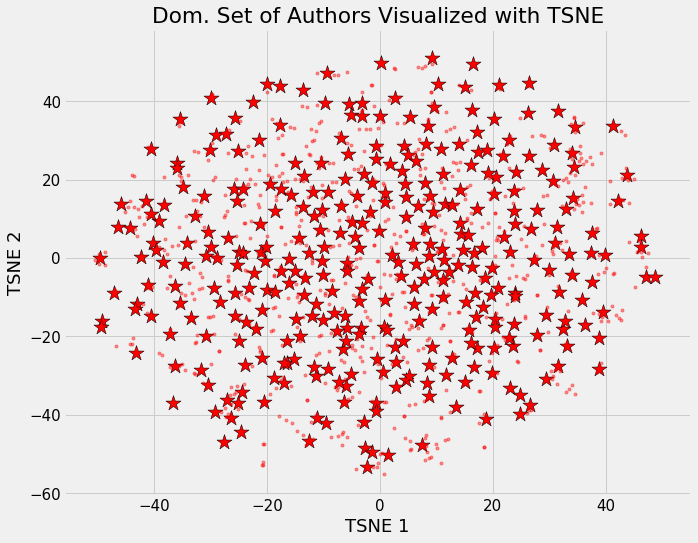

In [156]:
plt.figure(figsize = (10, 8))
plt.plot(author_dim_red[:, 0], author_dim_red[:, 1], 'r.', alpha = 0.4)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Dom. Set of Authors Visualized with TSNE');

for author in dom_set:
    
    x, y = author_dim_red[author_index[author], 0], author_dim_red[author_index[author], 1];
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k');

Now, if we plot the maximum independent set, we see that the authors tend to be mostly around the margins of the cloud.

In [160]:
max_independent_set = ['d huse',
  'd poilblanc',
  'e dagotto',
  'e jeckelmann',
  'f pollmann',
  'g chan',
  'g sierra',
  'g vidal',
  'h jiang',
  'i affleck',
  'm banuls',
  'm lewenstein',
  'p calabrese',
  'r noack',
  's gong',
  's montangero',
  't nishino',
  't osborne',
  'u schollwoeck',
  'x chen']

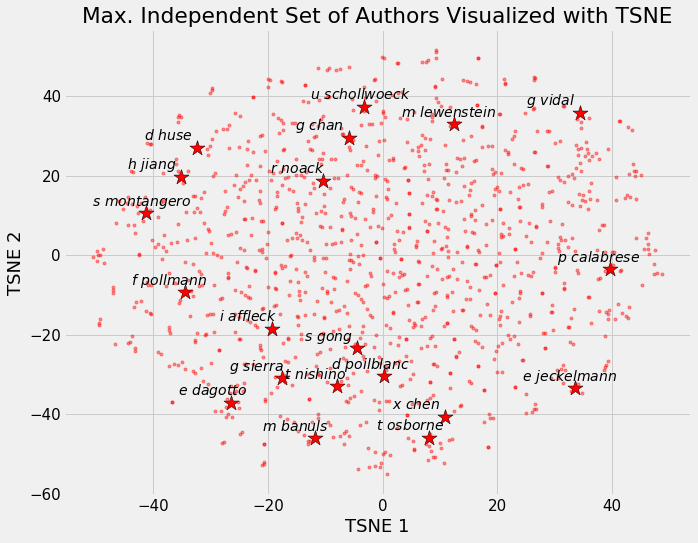

In [162]:
plt.figure(figsize = (10, 8))
plt.plot(author_dim_red[:, 0], author_dim_red[:, 1], 'r.', alpha = 0.4)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Max. Independent Set of Authors Visualized with TSNE');

for author in max_independent_set:
    
    x, y = author_dim_red[author_index[author], 0], author_dim_red[author_index[author], 1];
    # Italize book title using latex
    s =  ''.join([' $\it{' + word + '}$' for word in author.split()])
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k')
    _ = plt.text(x - 10, y + 2, s, fontsize = 14);

The most connected authors (according to closeness centrality) appear roughly opposed in two groups along the second component. Note that Philippe Corboz and Matthias Troyer collapse in this graph due to their commonly shared collaborators.

In [163]:
most_connected_authors = ['u schollwoeck',
                          'm troyer',
                          'a feiguin',
                          'i mcculloch', 
                          'f verstraete',
                          'a laeuchli',
                          's white',
                          'p corboz',
                          'r noack',
                          'g vidal']

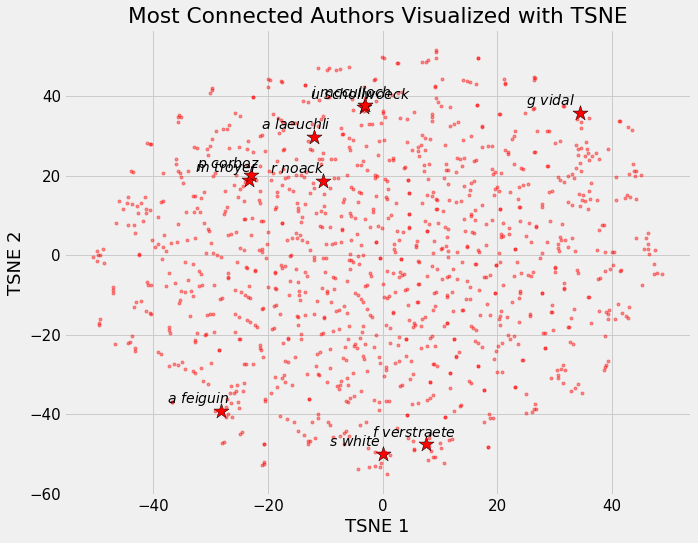

In [164]:
plt.figure(figsize = (10, 8))
plt.plot(author_dim_red[:, 0], author_dim_red[:, 1], 'r.', alpha = 0.4)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Most Connected Authors Visualized with TSNE');

for author in most_connected_authors:
    
    x, y = author_dim_red[author_index[author], 0], author_dim_red[author_index[author], 1];
    # Italize book title using latex
    s =  ''.join([' $\it{' + word + '}$' for word in author.split()])
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k')
    _ = plt.text(x - 10, y + 2, s, fontsize = 14);

We can also visualize the embeddings for the papers.

In [83]:
paper_dim_red = TSNE(2, metric = 'cosine').fit_transform(paper_weights)

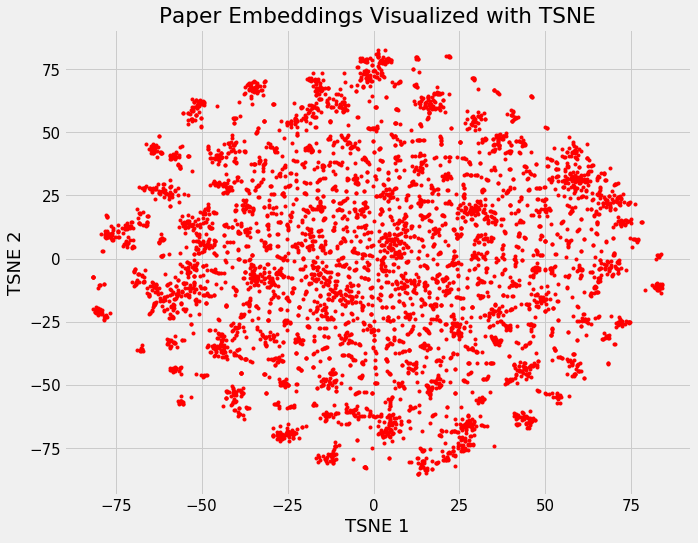

In [84]:
plt.figure(figsize = (10, 8))
plt.plot(paper_dim_red[:, 0], paper_dim_red[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Paper Embeddings Visualized with TSNE');

Let us see how the rating given by Nishino:

* **1:** "major technical or conceptual advances, cool applications and good reviews"
* **0:** Regular preprint
* **-1:** "related field"

In [85]:
n_rating = np.zeros(len(index_paper), dtype=int)

for i in index_paper:
    n_rating[i] = arxiv[arxiv.arXiv_id==index_paper[i]].Nishino_Rating.values[0]

In [86]:
ints, ratings = pd.factorize(n_rating)

In [87]:
ratings

array([ 0,  1, -1])

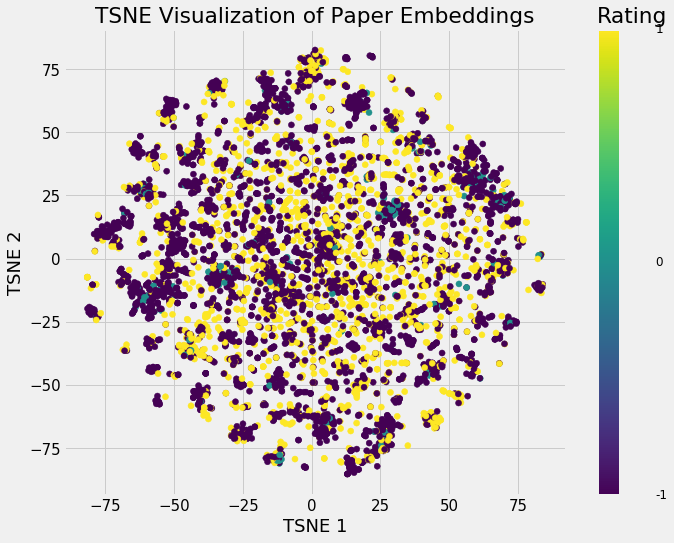

In [88]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(paper_dim_red[:, 0], paper_dim_red[:, 1], 
            c = ints)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
ratings = sorted(ratings)
for j, lab in enumerate(ratings):
    cbar.ax.text(5, j, lab, ha='left', va='center', fontsize=12)
cbar.ax.set_title('Rating', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Paper Embeddings');

We can also separate by year:

In [89]:
paper_year = np.zeros(len(index_paper), dtype=int)

for i in index_paper:
    paper_year[i] = str(arxiv[arxiv.arXiv_id==index_paper[i]].submitted.values[0])[:4]

In [90]:
ints, years = pd.factorize(paper_year)

In [91]:
years

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2016, 2015, 2017, 2018])

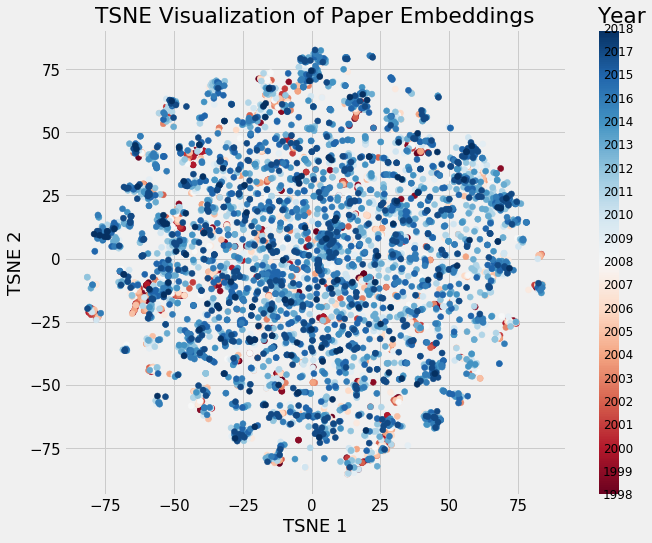

In [92]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(paper_dim_red[:, 0], paper_dim_red[:, 1], 
            c = ints, cmap = plt.cm.RdBu)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
ratings = sorted(ratings)
for j, lab in enumerate(years):
    cbar.ax.text(5, j, lab, ha='left', va='center', fontsize=12)
cbar.ax.set_title('Year', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Paper Embeddings');